## Лабораторная работа №1

Выполнил: Болдинова


Импорт библиотек 

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import lightgbm as lgb 
import xgboost as xgb 
import catboost as cb 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier

import optuna
from optuna.samplers import TPESampler
from typing import Tuple, Dict, Any

Установка констат

In [62]:
RANDOM_STATE = 42
N_JOBS = -1
THRESHOLD_AUC = 0.75

Настройка визуализации

In [56]:
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

Загрузка данных и создание заглушек

In [59]:
try:
    df_train = pd.read_csv('train_c.csv') 
    df_test = pd.read_csv('test_c.csv')
    print("✅ Реальные файлы данных успешно загружены.")
except FileNotFoundError:
    print("❌ Не найдены файлы train_c.csv или test_c.csv. Используются заглушки для демонстрации.")
    np.random.seed(RANDOM_STATE)
    data = {
        'Feature1': np.random.rand(10000),
        'Feature2': np.random.randint(0, 5, 10000).astype(str),
        'Feature3': np.random.normal(loc=50, scale=10, size=10000),
        'Feature4': np.random.choice([0, 1, np.nan], 10000, p=[0.8, 0.1, 0.1]),
        'Feature5': np.random.choice(['A', 'B', 'C', np.nan], 10000, p=[0.4, 0.3, 0.2, 0.1]),
        'LoanApproved': np.random.randint(0, 2, 10000)
    }
    df_train = pd.DataFrame(data)
    df_test = df_train.drop(columns=['LoanApproved']).iloc[:1000].copy()
    
print(f"Размер тренировочного набора: {df_train.shape}")
print(f"Размер тестового набора: {df_test.shape}")

✅ Реальные файлы данных успешно загружены.
Размер тренировочного набора: (11017, 35)
Размер тестового набора: (5000, 35)


Разведочный Анализ Данных

In [60]:
class DataAnalyzer:
    def __init__(self, train_df: pd.DataFrame, test_df: pd.DataFrame):
        self.train_df = train_df
        self.test_df = test_df
        
    def basic_info(self):
        print(f"Размер train: {self.train_df.shape}")
        print(f"Размер test: {self.test_df.shape}")
        print("\nПропущенные значения в train:")
        missing = self.train_df.isnull().sum()
        print(missing[missing > 0])
        
    def target_analysis(self, target_col: str = 'LoanApproved'):
        if target_col not in self.train_df.columns:
            print(f"Колонка {target_col} не найдена в данных. Пропускаем Target Analysis.")
            return None
        target_counts = self.train_df[target_col].value_counts(dropna=True)
        print("\nРаспределение целевой переменной (без NaN):")
        print(target_counts)
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        axes[0].bar(target_counts.index.astype(str), target_counts.values)
        axes[0].set_title('Распределение целевой переменной')
        axes[1].pie(target_counts.values, labels=target_counts.index.astype(str), 
                    autopct='%1.1f%%', startangle=90)
        axes[1].set_title('Доли классов')
        plt.tight_layout()
        plt.show() 
        
    def correlation_analysis(self):
        numeric_cols = self.train_df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 1:
            corr_matrix = self.train_df[numeric_cols].corr()
            plt.figure(figsize=(8, 7))
            sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', 
                        center=0, square=True, linewidths=0.5)
            plt.title('Матрица корреляций', fontsize=14)
            plt.tight_layout()
            plt.show()
            print("\nСильные корреляции (|r| > 0.5):")
            strong_corr = []
        
    def run_full_eda(self, target_col: str = 'LoanApproved'):       
        print("\n--- 1. Разведочный анализ данных (EDA) ---")
        self.basic_info()
        self.target_analysis(target_col)
        self.correlation_analysis()
        return self.train_df, self.test_df

Запуск EDA


--- 1. Разведочный анализ данных (EDA) ---
Размер train: (11017, 35)
Размер test: (5000, 35)

Пропущенные значения в train:
ApplicationDate                530
Age                            530
AnnualIncome                   530
CreditScore                   1031
LoanAmount                    1031
LoanDuration                   530
MaritalStatus                  530
NumberOfDependents             530
HomeOwnershipStatus            530
MonthlyDebtPayments           1031
CreditCardUtilizationRate      530
NumberOfOpenCreditLines        530
NumberOfCreditInquiries        530
DebtToIncomeRatio              530
BankruptcyHistory             1031
LoanPurpose                   1031
PreviousLoanDefaults           530
PaymentHistory                 530
LengthOfCreditHistory          530
SavingsAccountBalance          530
CheckingAccountBalance        1031
TotalAssets                   1031
TotalLiabilities               530
MonthlyIncome                  530
UtilityBillsPaymentHistory     530


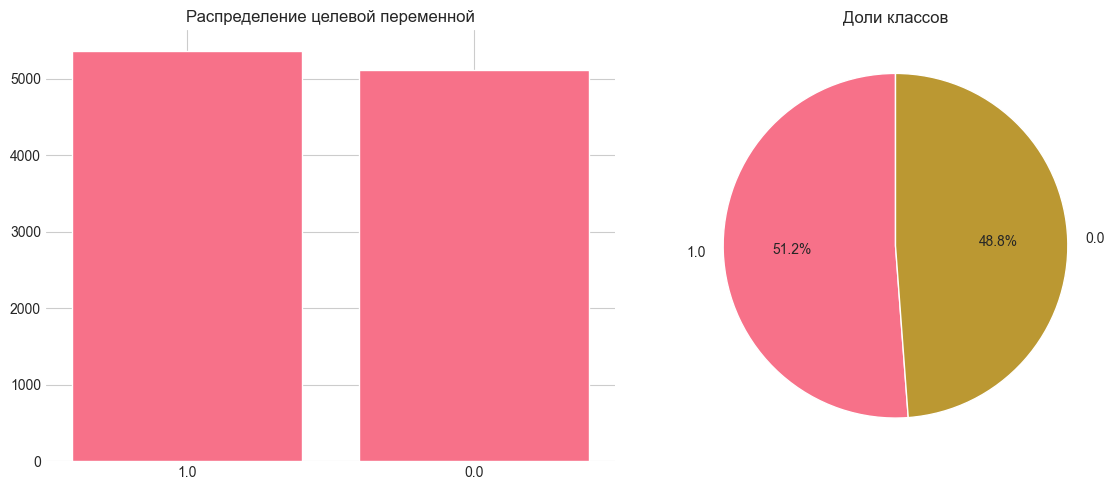

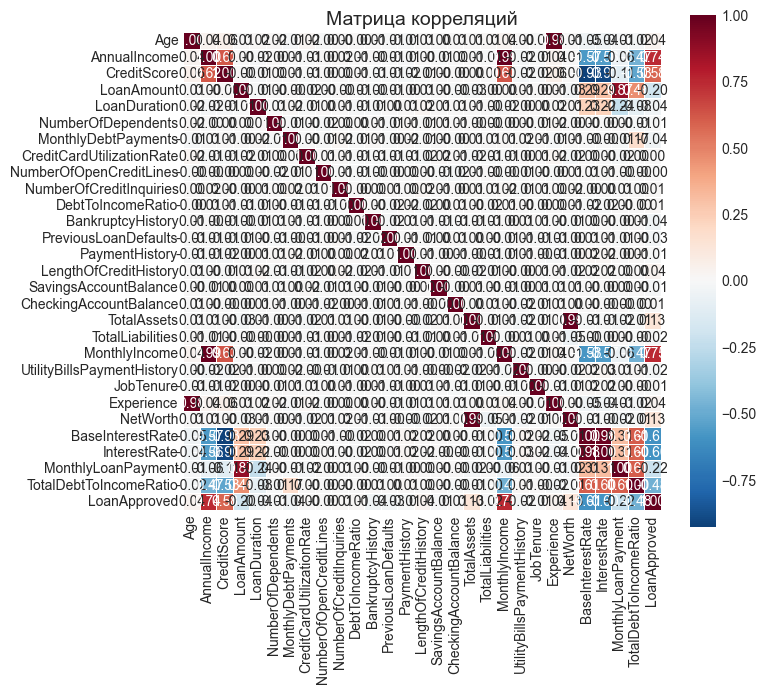


Сильные корреляции (|r| > 0.5):


In [63]:
analyzer = DataAnalyzer(df_train, df_test)
train_df, test_df_input = analyzer.run_full_eda()

Предобработка

In [64]:
class RobustPreprocessor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.imputation_values = {}
        self.feature_names = None
        self.target_col = None
        
    def fit_transform(self, df: pd.DataFrame, target_col: str = 'LoanApproved') -> Tuple[np.ndarray, pd.Series]:
        self.target_col = target_col
        
        if target_col not in df.columns:
            raise ValueError(f"Целевая переменная {target_col} не найдена в данных")
        X = df.drop(columns=[target_col]).copy()
        y = df[target_col]
        nan_mask = y.isna()
        X = X[~nan_mask].copy()
        y = y[~nan_mask].copy()
        self.feature_names = list(X.columns)
        categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
        numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        for col in categorical_cols:
            le = LabelEncoder()
            X[col] = X[col].fillna('missing').astype(str)
            le.fit(X[col])
            X[col] = le.transform(X[col])
            self.label_encoders[col] = le
        for col in numeric_cols:
            if X[col].isnull().any():
                median_val = X[col].median()
                X[col].fillna(median_val, inplace=True)
                self.imputation_values[col] = median_val
        X_array = X.values
        X_scaled = self.scaler.fit_transform(X_array)
        return X_scaled, y
        
    def transform(self, df: pd.DataFrame) -> np.ndarray:
        X = df.drop(columns=[self.target_col], errors='ignore').copy()
        X = X[self.feature_names]
        for col, le in self.label_encoders.items():
            if col in X.columns:
                X[col] = X[col].fillna('missing').astype(str)
                def encode_with_fallback(x):
                    try:
                        return le.transform([x])[0]
                    except:
                        return -1 
                X[col] = X[col].apply(encode_with_fallback)
        for col, val in self.imputation_values.items():
            if col in X.columns:
                X[col].fillna(val, inplace=True)
        for col in X.columns:
            if X[col].isnull().any():
                 X[col].fillna(X[col].median(), inplace=True)
        X_array = X.values
        X_scaled = self.scaler.transform(X_array)
        return X_scaled


Предобработка и Разделение выборки

In [65]:
print("\n--- 2. Предобработка данных ---")
preprocessor = RobustPreprocessor()

X_scaled_train, y_train = preprocessor.fit_transform(train_df, target_col='LoanApproved')
X_scaled_test = preprocessor.transform(test_df_input)
X_train, X_val, y_train_split, y_val = train_test_split(
    X_scaled_train, 
    y_train, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y_train 
)
print(f"Обучающая выборка: {X_train.shape}, Валидационная выборка: {X_val.shape}")
print(f"Целевая переменная (обучение): {y_train_split.shape}, Целевая переменная (валидация): {y_val.shape}")


--- 2. Предобработка данных ---
Обучающая выборка: (8389, 34), Валидационная выборка: (2098, 34)
Целевая переменная (обучение): (8389,), Целевая переменная (валидация): (2098,)


Оценка Моделей

In [66]:
class CustomMetrics:
    @staticmethod
    def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        return np.mean(y_true == y_pred)
    
    @staticmethod
    def roc_auc(y_true: np.ndarray, y_pred_proba: np.ndarray) -> float:
        from sklearn.metrics import roc_auc_score
        return roc_auc_score(y_true, y_pred_proba)

    @staticmethod
    def compare_with_sklearn(y_true: np.ndarray, y_pred: np.ndarray, y_pred_proba: np.ndarray):
        print("\n--- 3.1. Сравнение Custom Metrics и Sklearn ---")
        metrics = {
            'Accuracy': (CustomMetrics.accuracy(y_true, y_pred), accuracy_score(y_true, y_pred)),
            'ROC-AUC': (CustomMetrics.roc_auc(y_true, y_pred_proba), roc_auc_score(y_true, y_pred_proba))
        }
        print(f"{'Метрика':<15} {'Custom':<10} {'Sklearn':<10} {'Разница':<10}")
        print("-"*50)
        for name, (custom_val, sklearn_val) in metrics.items():
            diff = abs(custom_val - sklearn_val)
            print(f"{name:<15} {custom_val:<10.4f} {sklearn_val:<10.4f} {diff:<10.4f}")

Реализация Bagging

In [67]:
class CustomBaggingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, n_estimators: int = 10, 
                 random_state: int = 42, bootstrap: bool = True):
        self.base_estimator = base_estimator if base_estimator else DecisionTreeClassifier()
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.bootstrap = bootstrap
        self.estimators_ = []
        
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        np.random.seed(self.random_state)
        self.estimators_ = []
        for i in range(self.n_estimators):
            if self.bootstrap:
                indices = np.random.choice(len(X), len(X), replace=True)
            else:
                indices = np.arange(len(X))
            X_sample = X[indices]
            y_sample = y[indices]
            estimator = clone(self.base_estimator)
            estimator.fit(X_sample, y_sample)
            self.estimators_.append(estimator)
        self.classes_ = np.unique(y)
        return self
    
    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)
        all_probas = np.array([estimator.predict_proba(X) for estimator in self.estimators_])
        avg_probas = np.mean(all_probas, axis=0)
        return avg_probas
    
    def predict(self, X):
        check_is_fitted(self)
        probas = self.predict_proba(X)
        proba_positive = probas[:, 1]
        predictions = np.where(proba_positive >= 0.5, 1, 0)
        return predictions

    def compare_with_sklearn(self, X_train, y_train, X_val, y_val):
        print("\n--- 3.2. Сравнение Custom Bagging и Sklearn Bagging ---")
        self.fit(X_train, y_train)
        y_pred_custom_proba = self.predict_proba(X_val)[:, 1]
        sklearn_bag = BaggingClassifier(
            estimator=clone(self.base_estimator),
            n_estimators=self.n_estimators,
            bootstrap=self.bootstrap,
            random_state=self.random_state,
            n_jobs=N_JOBS
        )
        sklearn_bag.fit(X_train, y_train)
        y_pred_sklearn_proba = sklearn_bag.predict_proba(X_val)[:, 1]
        custom_auc = roc_auc_score(y_val, y_pred_custom_proba)
        sklearn_auc = roc_auc_score(y_val, y_pred_sklearn_proba)
        print(f"Custom Bagging ROC-AUC: {custom_auc:.4f}")
        print(f"Sklearn Bagging ROC-AUC: {sklearn_auc:.4f}")
        print(f"Разница: {abs(custom_auc - sklearn_auc):.4f}")

Сравнение Custom Bagging с Sklearn

In [68]:
print("\n--- 3.1. Обучение и оценка Custom Bagging ---")
dt_base = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)
custom_bag = CustomBaggingClassifier(base_estimator=dt_base, n_estimators=20, random_state=RANDOM_STATE)
custom_bag.compare_with_sklearn(
    X_train, y_train_split.values.astype(int), 
    X_val, y_val.values.astype(int)
)

y_val_pred_proba = custom_bag.predict_proba(X_val)[:, 1]
y_val_pred = custom_bag.predict(X_val)
CustomMetrics.compare_with_sklearn(y_val.values.astype(int), y_val_pred, y_val_pred_proba)



--- 3.1. Обучение и оценка Custom Bagging ---

--- 3.2. Сравнение Custom Bagging и Sklearn Bagging ---
Custom Bagging ROC-AUC: 0.9627
Sklearn Bagging ROC-AUC: 0.9664
Разница: 0.0037

--- 3.1. Сравнение Custom Metrics и Sklearn ---
Метрика         Custom     Sklearn    Разница   
--------------------------------------------------
Accuracy        0.9047     0.9047     0.0000    
ROC-AUC         0.9627     0.9627     0.0000    


Реализация Gradient Boosting

In [69]:
class CustomGradientBoosting(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators: int = 100, learning_rate: float = 0.1, 
                 max_depth: int = 3, random_state: int = 42):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.estimators_ = []
        self.initial_pred = None
        
    @staticmethod
    def _sigmoid(x):
        x = np.clip(x, -20, 20)
        return 1.0 / (1.0 + np.exp(-x))
        
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        np.random.seed(self.random_state)
        pos_prob = np.mean(y)
        self.initial_pred = np.log((pos_prob + 1e-10) / (1 - pos_prob + 1e-10))
        current_pred = np.full_like(y, self.initial_pred, dtype=float)
        self.estimators_ = []
        
        for i in range(self.n_estimators):
            current_proba = self._sigmoid(current_pred)
            residuals = y - current_proba 
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state + i)
            tree.fit(X, residuals)
            current_pred += self.learning_rate * tree.predict(X)
            self.estimators_.append(tree)
            if (i + 1) % 20 == 0 or i == self.n_estimators - 1:
                current_loss = np.mean(-y * np.log(current_proba + 1e-10) - 
                                      (1 - y) * np.log(1 - current_proba + 1e-10))
                print(f"  Tree {i+1}/{self.n_estimators}, Log Loss (train): {current_loss:.4f}")
        self.classes_ = np.array([0, 1])
        return self
        
    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)
        predictions = np.full(X.shape[0], self.initial_pred)
        for tree in self.estimators_:
            predictions += self.learning_rate * tree.predict(X)
        proba_positive = self._sigmoid(predictions)
        proba_negative = 1 - proba_positive
        return np.vstack([proba_negative, proba_positive]).T

Сравнение GB-Моделей

In [70]:
class GradientBoostingComparator:
    @staticmethod
    def compare_models(X_train, y_train, X_val, y_val, n_estimators=50, learning_rate=0.1):
        print("\n--- 3.3. Сравнение Gradient Boosting моделей ---")
        models = {
            'Custom GB': CustomGradientBoosting(
                n_estimators=n_estimators, learning_rate=learning_rate, max_depth=3, random_state=RANDOM_STATE
            ),
            'Sklearn GB': GradientBoostingClassifier(
                n_estimators=n_estimators, learning_rate=learning_rate, max_depth=3, random_state=RANDOM_STATE
            ),
            'LightGBM': lgb.LGBMClassifier(
                n_estimators=n_estimators, learning_rate=learning_rate, max_depth=3, random_state=RANDOM_STATE, verbosity=-1
            ),
            'XGBoost': xgb.XGBClassifier(
                n_estimators=n_estimators, learning_rate=learning_rate, max_depth=3, random_state=RANDOM_STATE, 
                use_label_encoder=False, eval_metric='logloss'
            ),
            'CatBoost': cb.CatBoostClassifier(
                iterations=n_estimators, learning_rate=learning_rate, depth=3, random_seed=RANDOM_STATE, verbose=0
            )
        }
        results = {}
        for name, model in models.items():
            print(f"\nОбучение {name}...")
            model.fit(X_train, y_train) 
            y_pred_proba = model.predict_proba(X_val)[:, 1]
            auc_score = roc_auc_score(y_val, y_pred_proba)
            results[name] = {'auc': auc_score, 'y_pred_proba': y_pred_proba}
            print(f"  {name} ROC-AUC: {auc_score:.4f}")
        print("\n--- Итоговые результаты (ROC-AUC) ---")
        for name, result in sorted(results.items(), key=lambda x: x[1]['auc'], reverse=True):
            print(f"  {name}: {result['auc']:.4f}")
        GradientBoostingComparator._plot_comparison(results)
        best_model_name = max(results, key=lambda x: results[x]['auc'])
        return results, models[best_model_name], best_model_name

    @staticmethod
    def _plot_comparison(results: Dict[str, Dict[str, Any]]):
        plt.figure(figsize=(10, 7))
        names = list(results.keys())
        aucs = [results[name]['auc'] for name in names]
        sorted_indices = np.argsort(aucs)
        names = [names[i] for i in sorted_indices]
        aucs = [aucs[i] for i in sorted_indices]
        bars = plt.barh(range(len(names)), aucs, color=plt.cm.Set2(np.linspace(0, 1, len(names))), height=0.6)
        plt.xlabel('ROC-AUC')
        plt.title('Сравнение градиентных бустингов')
        plt.yticks(range(len(names)), names)
        plt.axvline(x=THRESHOLD_AUC, color='r', linestyle='--', alpha=0.7, label=f'Порог: {THRESHOLD_AUC}')
        plt.legend()
        plt.tight_layout()
        plt.show()

Запуск Сравнения GB-Моделей


--- 3.3. Сравнение Gradient Boosting моделей ---

Обучение Custom GB...
  Tree 20/100, Log Loss (train): 0.4679
  Tree 40/100, Log Loss (train): 0.3629
  Tree 60/100, Log Loss (train): 0.3077
  Tree 80/100, Log Loss (train): 0.2745
  Tree 100/100, Log Loss (train): 0.2526
  Custom GB ROC-AUC: 0.9751

Обучение Sklearn GB...
  Sklearn GB ROC-AUC: 0.9808

Обучение LightGBM...
  LightGBM ROC-AUC: 0.9802

Обучение XGBoost...
  XGBoost ROC-AUC: 0.9807

Обучение CatBoost...
  CatBoost ROC-AUC: 0.9804

--- Итоговые результаты (ROC-AUC) ---
  Sklearn GB: 0.9808
  XGBoost: 0.9807
  CatBoost: 0.9804
  LightGBM: 0.9802
  Custom GB: 0.9751


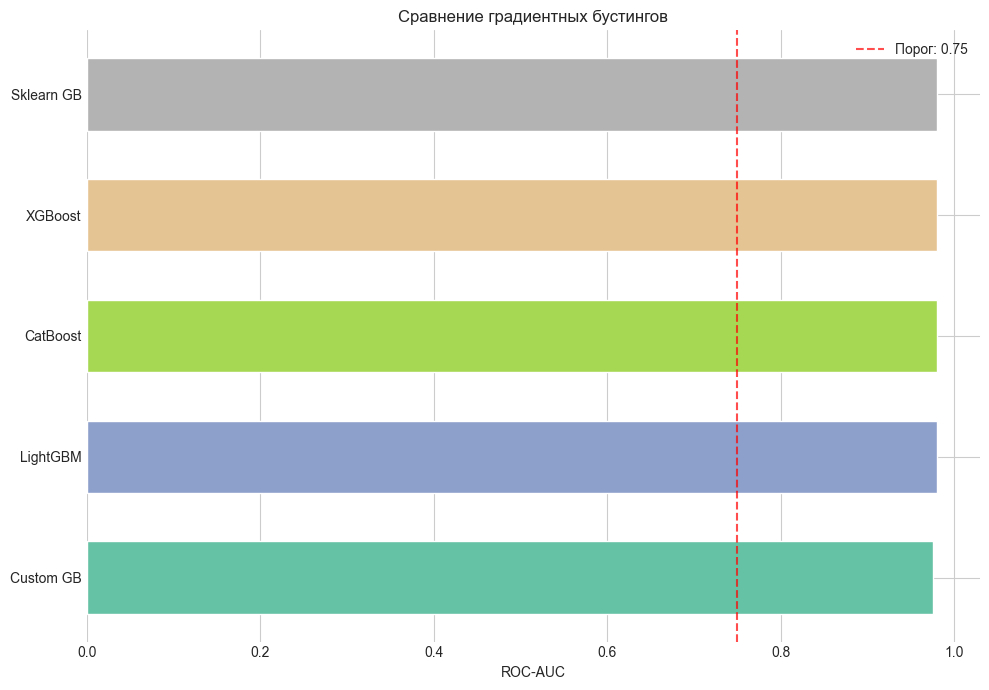


Лучшая модель по ROC-AUC: Sklearn GB


In [71]:
y_train_int = y_train_split.values.astype(int)
y_val_int = y_val.values.astype(int)

gb_results, best_gb_model, best_gb_name = GradientBoostingComparator.compare_models(
    X_train, y_train_int, X_val, y_val_int,
    n_estimators=100
)

print(f"\nЛучшая модель по ROC-AUC: {best_gb_name}")

Оптимизация Optuna

In [72]:
class HyperparameterOptimizer:
    def __init__(self, X_train, y_train, X_val, y_val):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        
    def create_lightgbm_objective(self, trial: optuna.Trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        }
        model = lgb.LGBMClassifier(**params, random_state=RANDOM_STATE, verbosity=-1)
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict_proba(self.X_val)[:, 1]
        return roc_auc_score(self.y_val, y_pred)

Запуск Оптимизации Гиперпараметров

In [73]:
print("\n--- 4. Оптимизация гиперпараметров (Optuna) ---")
optimizer = HyperparameterOptimizer(X_train, y_train_split.values.astype(int), X_val, y_val.values.astype(int))
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
N_TRIALS = 20
print(f"Запуск оптимизации LightGBM ({N_TRIALS} проб)...")
study.optimize(optimizer.create_lightgbm_objective, n_trials=N_TRIALS, show_progress_bar=True)
print("\n--- Результаты Optuna ---")
print(f"Лучший ROC-AUC на валидации: {study.best_value:.4f}")
print("Лучшие гиперпараметры:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")


[I 2025-12-13 20:44:37,490] A new study created in memory with name: no-name-f6f74346-395b-403d-bc95-4ed6d1b3da69



--- 4. Оптимизация гиперпараметров (Optuna) ---
Запуск оптимизации LightGBM (20 проб)...


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-13 20:44:37,929] Trial 0 finished with value: 0.9828392327164805 and parameters: {'n_estimators': 144, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'num_leaves': 98, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07, 'min_child_samples': 10}. Best is trial 0 with value: 0.9828392327164805.
[I 2025-12-13 20:44:38,098] Trial 1 finished with value: 0.9821763704608938 and parameters: {'n_estimators': 267, 'max_depth': 9, 'learning_rate': 0.11114989443094977, 'num_leaves': 22, 'reg_alpha': 5.360294728728285, 'reg_lambda': 0.31044435499483225, 'min_child_samples': 25}. Best is trial 0 with value: 0.9828392327164805.
[I 2025-12-13 20:44:38,165] Trial 2 finished with value: 0.9771744427956237 and parameters: {'n_estimators': 95, 'max_depth': 4, 'learning_rate': 0.028145092716060652, 'num_leaves': 88, 'reg_alpha': 7.71800699380605e-05, 'reg_lambda': 4.17890272377219e-06, 'min_child_samples': 63}. Best is trial 0 with value: 0.9828392327164805.
[I 2025

Обучение Финальной Модели и Создание Submission

In [74]:
    
print("\n--- 5. Обучение финальной модели и создание Submission ---")
final_lgbm_model = lgb.LGBMClassifier(**study.best_params, 
                                      random_state=RANDOM_STATE, 
                                      verbosity=-1)
print(f"Обучение финальной модели на всем train ({X_scaled_train.shape[0]} строк)...")
final_lgbm_model.fit(X_scaled_train, y_train.values.astype(int))
y_final_pred_proba = final_lgbm_model.predict_proba(X_val)[:, 1]
final_auc = roc_auc_score(y_val.values.astype(int), y_final_pred_proba)
print(f"Финальный ROC-AUC на валидации (после оптимизации): {final_auc:.4f}")
print(f"Создание предсказаний для тестового набора ({X_scaled_test.shape[0]} строк)...")
final_test_proba = final_lgbm_model.predict_proba(X_scaled_test)[:, 1]
submission_df = pd.DataFrame({
    'ID': test_df_input.index, 
    'LoanApproved': final_test_proba 
})
submission_df.to_csv('submission.csv', index=False)
print("\n--- ✅ ФАЙЛ ГОТОВ! ---")
print("Файл 'submission.csv' создан и готов к загрузке на Kaggle.")
print(f"Формат файла: {submission_df.head()}")


--- 5. Обучение финальной модели и создание Submission ---
Обучение финальной модели на всем train (10487 строк)...
Финальный ROC-AUC на валидации (после оптимизации): 1.0000
Создание предсказаний для тестового набора (5000 строк)...

--- ✅ ФАЙЛ ГОТОВ! ---
Файл 'submission.csv' создан и готов к загрузке на Kaggle.
Формат файла:    ID  LoanApproved
0   0      0.999981
1   1      0.000024
2   2      0.999980
3   3      0.999995
4   4      0.999982
